# 20240130

## Online Retail Data set 기반으로 고객 세그멘테이션을 위한 군집분석을 다음 사항을 준수하여 수행하세요.
- 목표 :
  - 타깃 마케팅 : 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공.
  - 고객의 상품 구매 이력 데이터 기반에 기초한 타깃 마케팅
- 군집화 방법 :기본적인 고객 분석 요소인 RFM 기법을 이용해서 고객을 군집화
  - RECENCY(R): 가장 최근 상품 구입 일에서 오늘까지의 기간
  - FREQUENCY(F): 상품 구매 횟수
  - MONETARY VALUE(M) : 총 구매 금액
- 데이터셋
  - UCI 에서 제공하는 Online Retail Data set
  - 데이터셋 칼럼 구성
    - InvoiceNo: 주문번호, ‘C’로 시작하는 것은 취소 주문
    - StockCode: 제품 코드(Item Code)
    - Description: 제품 설명
    - Quantity : 주문 제품 건수
    - InvoiceDate: 주문 일자
    - UnitPrice: 제품 단가
    - CustomerID: 고객 번호
    - Country: 국가명(주문 고객의 국적)

- 분석 가이드
  - 데이터 세트 로딩과 데이터 클렌징
    * Null 데이터 제거:  CustomerID의 Null 값이 많은 것으로 확인됨. 고객 세그멘이션을 수행하므로 고객 식별 번호가 없는 데이터는 삭제
    * 오류 데이터 삭제: 대표적인 오류 데이터는 Quantity 또는 UnitPrice 가 0보다 작은 경우. Quantity 가 0보다 작은 경우는 반환을 뜻하는 값으로 InvoiceNO 앞자리가 ‘C’로 되어있음. 분석의 효율성을 위해 삭제    
    * Country 칼럼의 주요 주문 고객 국가인 영국 데이터만을 필터링하여 선택
  - RFM 기반 데이터 가공
    * UnitPrice’(제품 단가), ‘Quantity’(주문 제품 건수)를 곱해서 주문 금액 칼럼 생성, CusmtomerID int형으로 형변환
    * 주문 금액, 주문 횟수가 특정 고객에게 과도하게 되어있는지 탐색<br>
      CustomerID로 group by 하여 TOP-5 구매 횟수 고객 ID 추출<br>
      CustomerID로 group by 하고 주문 금액 칼럼을 더하여 TOP-5 주문 금액 고객 ID 추출
    * 온라인 데이터 세트에 대해서 ‘InvocieNO(주문번호)’ + ‘StockCode(상품코드)’ 거의 1에 가까운 유일한 식별자 레벨로 되어있는지 확인
    * 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 변환 - 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 하여 세그멘테이션을 수행하기 위한 데이터 처리
    * 개별 고객 기준의 데이터 셋은 CustomerID, Recency, Frequency, Monetary 4개의 칼럼으로 구성
  - RFM 기반 고객 세그멘테이션
    * 온라인 판매 데이터는 소매업체로 추정되는 특정 고객의 대규모 주문이 포함되어 있어 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이가 있음을 왜곡된 데이터 분포도를 시각화하여 확인
    * 왜곡 정도가 매우 높은 데이터 세트에 K-평균을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행되기 때문에 StandScaler로 평균과 표준편차를 재조정한 후 시각화하여 군집화 결과를 확인. 시각화는 제공된 사용자 함수 이용하며 군집 개수를 2 ~ 5개 변화시키면서 수행
      - visualize_silhouette(cluster_lists, X_features)
      - visualize_kmeans_plot_multi(cluster_lists, X_features)    
    
    * 데이터 세트의 왜곡정도를 낮추기 위해 로그변환 이용하여 다시 시각화하여 군집화 결과를 확인
    * 3개 군집의 특징을 통계적 방법을 통해서 해석 및 활용 방안 수립

---------------------------------------------------------내가 푼거-----------------------------------------------------

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/KITA_1026/m5_ml/dataset/Online_Retail.xlsx')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [26]:
# 컬럼 추가 <- recency, 각 invoice line 별 구매금액,
df['Recency'] = (pd.to_datetime("2011-12-10") - df['InvoiceDate']).dt.days + 1

In [22]:
# MonetaryValue 칼럼 추가
df['MonetaryValue'] = df['Quantity']*df['UnitPrice']
df['MonetaryValue'].head()

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: MonetaryValue, dtype: float64

In [23]:
# 개별 고객 기준의 데이터 셋은 CustomerID, Recency, Frequency, Monetary 4개의 칼럼으로 구성 <- 데이터 프레임 index = Customer ID
# 필터링 <- CustomerID <- null 제거, Country = "United Kingdom", UnitPrice >0, quantity>0
# 필요한 컬럼: Recency, Frequency, Monetary,

df_analysis = df.where(df.Country == "United Kingdom").where(df.Quantity>0).where(df.UnitPrice>0).groupby('CustomerID').agg({'MonetaryValue': 'sum', 'InvoiceNo':'count', 'Recency':'min'})

df_analysis.rename(columns = {'InvoiceNo' : 'Frequency'}, inplace = True)

df_analysis = df_analysis[['Recency','Frequency','MonetaryValue']]

In [24]:
# CustomerID를 int로
df_analysis.index = df_analysis.index.astype(int)
df_analysis.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326.0,1,77183.60
12747,3.0,103,4196.01
12748,1.0,4595,33719.73
12749,4.0,199,4090.88
12820,4.0,59,942.34


In [25]:
df_analysis.describe()

,Recency,Frequency,MonetaryValue
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [27]:
#CustomerID로 group by 하여 TOP-5 구매 횟수 고객 ID 추출
#CustomerID로 group by 하여 주문 금액 칼럼을 더하여 TOP-5 주문 금액 고객 ID 추출

print(df_analysis.Frequency.sort_values(ascending=False)[:5])
print(df_analysis.MonetaryValue.sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: Frequency, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: MonetaryValue, dtype: float64


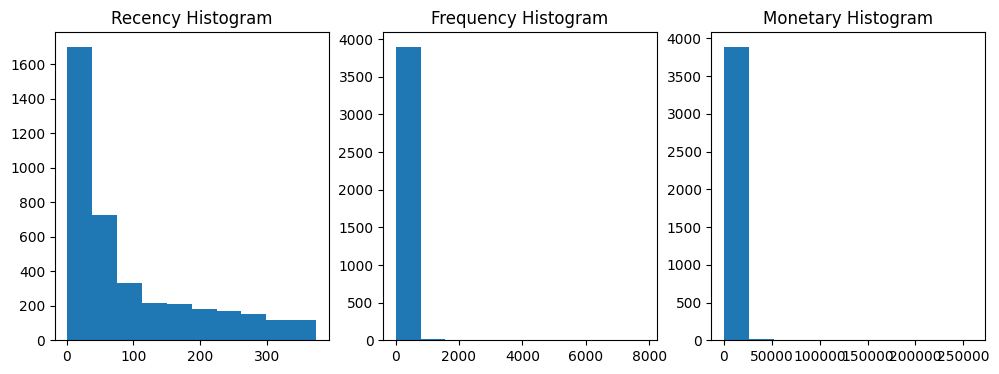

In [29]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1,ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(df_analysis['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(df_analysis['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(df_analysis['MonetaryValue'])

plt.show()

In [41]:
# 모든 칼럼에 StandScaler로 평균과 표준편차를 재조정
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples

scaler = StandardScaler()
scaled = scaler.fit_transform(df_analysis)
scaled
scaled_df = pd.DataFrame(scaled, columns=['Recency','Frequency','MonetaryValue'], index=df_analysis.index)
scaled_df.head()

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
labels = kmeans.fit_predict(scaled_df)

print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(scaled_df,labels)))

scaled_df['cluster_label'] = labels

실루엣 스코어는: 0.576


In [61]:
# 로그변환
# log_df = np.log1p(df_analysis)

# kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
# labels = kmeans.fit_predict(log_df)

# print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(log_df,labels)))

# log_df['cluster_label'] = labels

# Recency, Frequency, Monetary 컬럼에 np.log1p() 로 Log Transformation
df_analysis['Recency_log'] = np.log1p(df_analysis['Recency'])
df_analysis['Frequency_log'] = np.log1p(df_analysis['Frequency'])
df_analysis['Monetary_log'] = np.log1p(df_analysis['MonetaryValue'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = df_analysis[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
df_analysis['cluster_label'] = labels

print('실루엣 스코어는:{0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는:0.305


In [44]:
# 로그변환 후 standardized
# scaler = StandardScaler()
# log_stand = scaler.fit_transform(log_df)
# log_stand_df = pd.DataFrame(log_stand, columns=['Recency','Frequency','MonetaryValue'], index=df_analysis.index)

# kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
# labels = kmeans.fit_predict(log_stand_df)

# print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(log_stand_df,labels)))

# log_stand_df['cluster_label'] = labels

실루엣 스코어는: 0.305


### 군집 개수별로 군집화 구성을 시각화하는 사용자 함수

In [46]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, n_init='auto', max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, edgecolor='k', marker=markers[label], label=cluster_legend)
            # axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70, marker='o', edgecolor='k', facecolor='none')

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

In [47]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, n_init='auto', max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

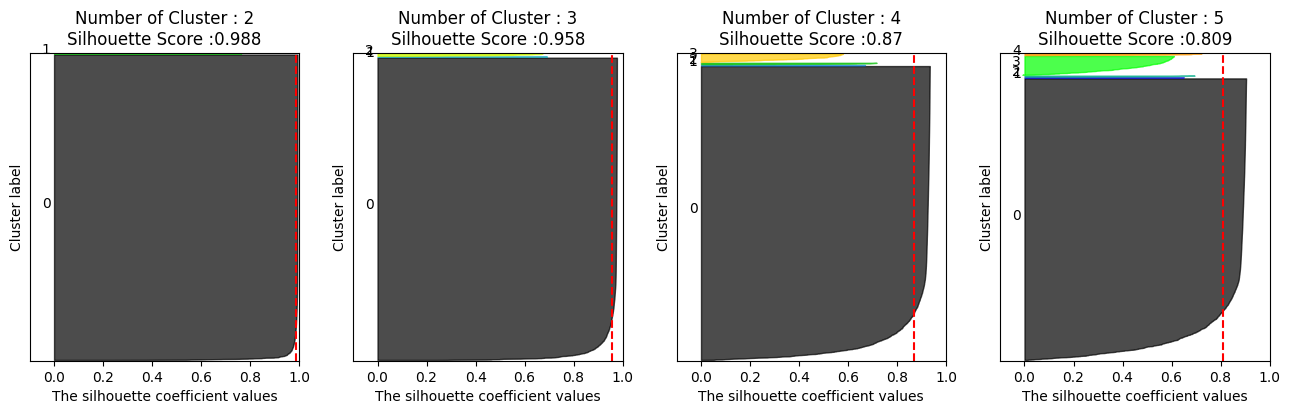

In [48]:
# 시각화 not scaled
visualize_silhouette([2,3,4,5], df_analysis[['Recency','Frequency','MonetaryValue']])

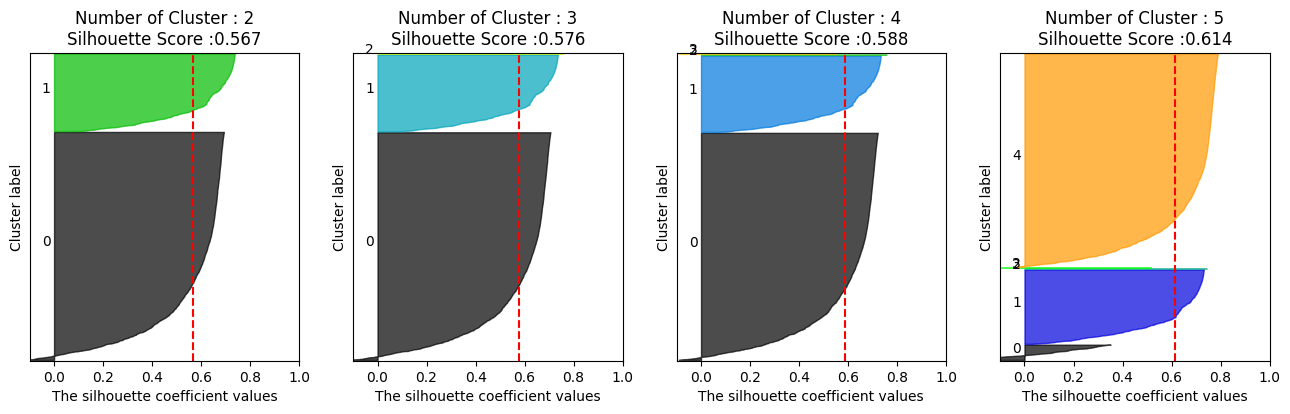

In [49]:
# 시각화 scaled
visualize_silhouette([2,3,4,5], scaled_df[['Recency','Frequency','MonetaryValue']])

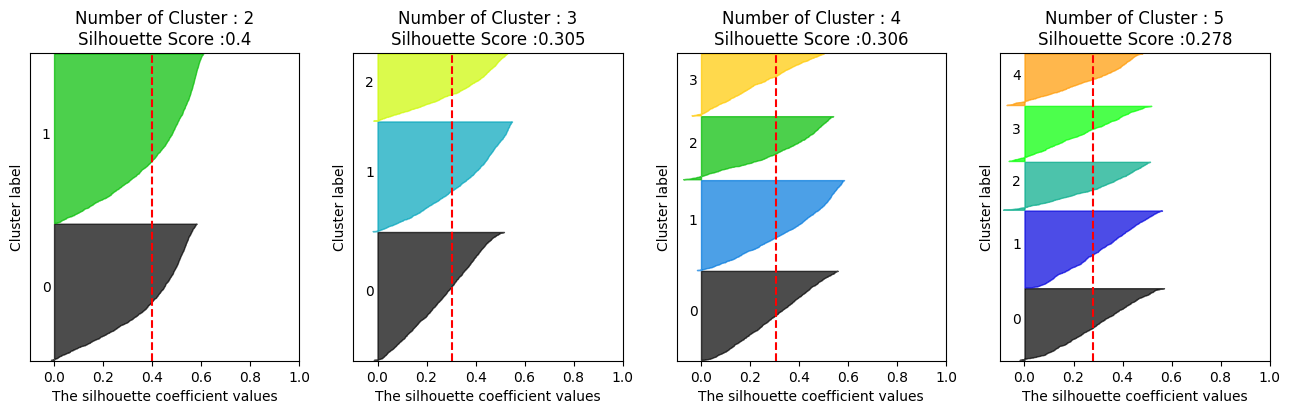

In [63]:
visualize_silhouette([2,3,4,5], X_features_scaled)

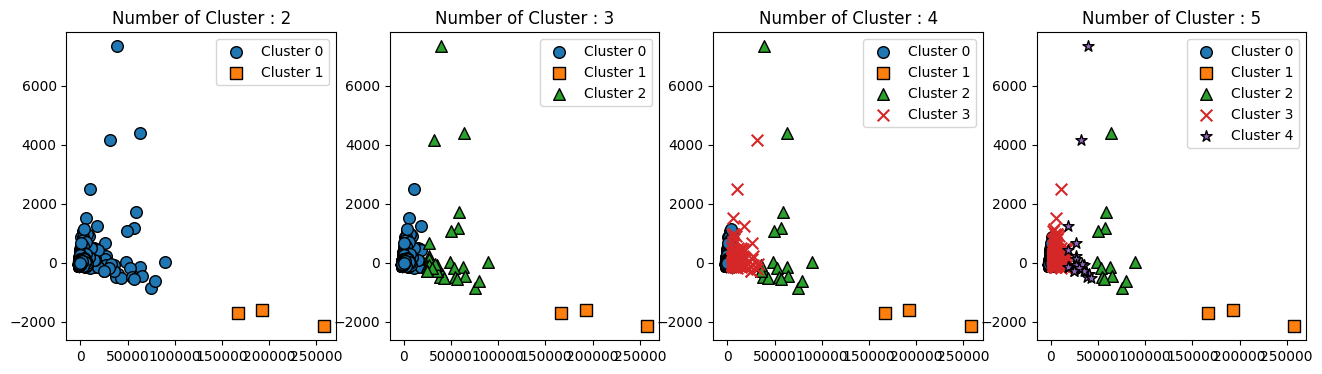

In [52]:
# 시각화 not scaled
visualize_kmeans_plot_multi([2,3,4,5], df_analysis[['Recency','Frequency','MonetaryValue']])

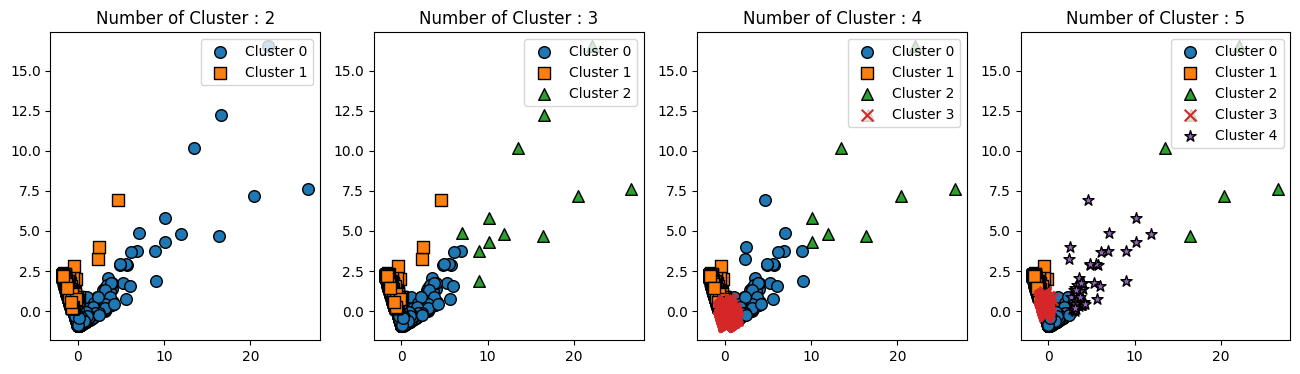

In [53]:
# 시각화 scaled
visualize_kmeans_plot_multi([2,3,4,5], scaled_df[['Recency','Frequency','MonetaryValue']])

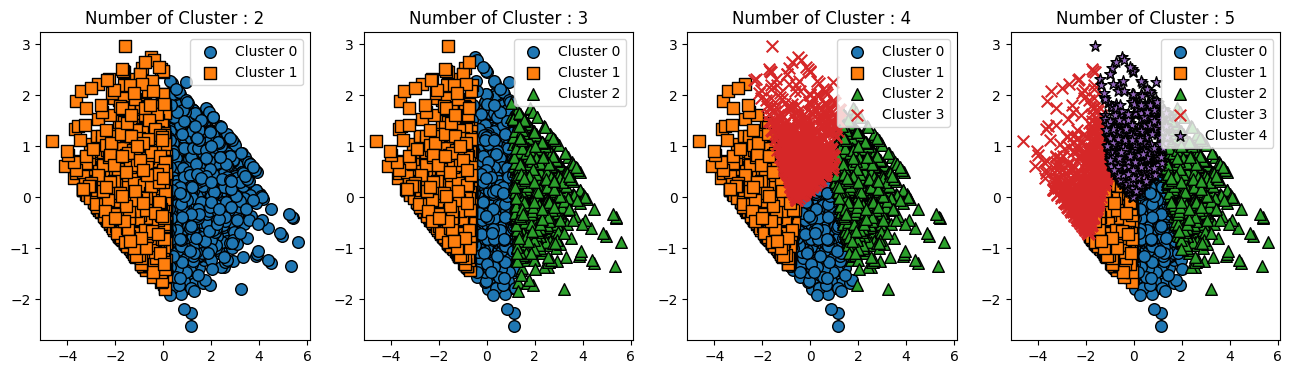

In [64]:
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)